### Imports

In [214]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [215]:
print(tf.config.list_physical_devices('GPU'))
tf.test.is_built_with_cuda()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

### VGG-19 Model until Feature Extraction

In [216]:
# Load the VGG-19 model without the top layers
feature_extractor = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
feature_extractor.trainable = False

# Display the model architecture to confirm
feature_extractor.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Layers for Content and Style

In [217]:
# Pick a layer in the middle for content, not too basic(early) or too deep(specific)
content_layers = ['block4_conv2']
# Pick a bunch of layers to get a comprehensive representation of style
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

### Model

In [218]:
selected_layers = content_layers + style_layers
selected_outputs = []

for layer_name in selected_layers:
    layer_output = feature_extractor.get_layer(layer_name).output
    selected_outputs.append(layer_output)

# Create the feature extractor model
model = tf.keras.models.Model(inputs=feature_extractor.input, outputs=selected_outputs)

### Compute Features for segregation

In [219]:
def compute_features(image):
    """Compute content and style features for a given image."""
    # Forward the image through the feature extractor
    all_features = model(image)
    
    # Split the features into content and style
    content_features = all_features[:len(content_layers)]
    style_features = all_features[len(content_layers):]
    
    return content_features, style_features

### Load & Pre-process Content & Style

In [220]:
def load_image(path):
    """Load an image from a file path and add a batch dimension."""
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3) # 0-255 pixel values
    image = tf.image.convert_image_dtype(image, tf.float32) # 0-1 pixel values
    image = tf.expand_dims(image, axis=0)
    return image

def preprocess_image(image, target_size=(224, 224)):
    """Resize and normalize the image for VGG-19."""
    image = tf.image.resize(image, target_size)
    image = tf.keras.applications.vgg19.preprocess_input(image * 255.0)  # VGG-19 preprocessing
    return image

def deprocess_image(image):
    """Utility function to convert a tensor into a valid image."""
    # Reverse the VGG-19 preprocessing
    image = image + np.array([103.939, 116.779, 123.68])
    image = image[:, :, ::-1]
    image = np.clip(image, 0, 255).astype('uint8')
    return image / 255.0

In [221]:
# Load the images
content_image_path = 'nature.png'
style_image_path = 'swiggle.jpg'

content_image = load_image(content_image_path)
style_image = load_image(style_image_path)

# Preprocess the images
content_image = preprocess_image(content_image)
style_image = preprocess_image(style_image)

### Extracting initial Content & Style features

In [222]:
# Get the specific features
content_features, _ = compute_features(content_image)
_, style_features = compute_features(style_image)

### Loss Function

In [223]:
# Content loss is just difference between content features of the generated images and content image
def content_loss(content_features, target_content_features):
    # Extract the tensor from each list
    content_tensor = content_features[0]
    target_content_tensor = target_content_features[0]
    return tf.reduce_sum(tf.square(content_tensor - target_content_tensor))

# Gram matrix
def gram_matrix(style_layer_features):
    """Calculate the Gram matrix for an input tensor."""
    # Flatten the feature maps and compute the outer product to get the Gram matrix
    channels = int(style_layer_features.shape[-1])
    a = tf.reshape(style_layer_features, [-1, channels])
    gram = tf.matmul(a, a, transpose_a=True)
    return gram
    
# Style loss for single feature output
def style_loss(style_feature, target_style_feature):
    """Calculate the style loss between the base style and the target style."""
    gram_base_style = gram_matrix(style_feature)
    gram_style_target = gram_matrix(target_style_feature)
    return tf.reduce_mean(tf.square(gram_base_style - gram_style_target))

# Total Style loss
def total_style_loss(style_features, target_style_features, style_weights):
    """Calculate the total style loss between the base style and the target style."""
    loss = 0
    for feature, target_feature, layer_name in zip(style_features, target_style_features, style_weights.keys()):
        layer_style_loss = style_loss(feature, target_feature)
        weighted_layer_style_loss = style_weights[layer_name] * layer_style_loss
        loss += weighted_layer_style_loss
    return loss

# Combining the loss
def compute_total_loss(generated_image, content_features, style_features, content_weight, style_weight, style_weights):
    gen_content_features, gen_style_features = compute_features(generated_image)
    # Compute content loss
    c_loss = content_loss(gen_content_features, content_features)
    # Compute style loss
    s_loss = total_style_loss(gen_style_features, style_features, style_weights)
    # Compute total loss
    total_loss = content_weight * c_loss + style_weight * s_loss
    
    return total_loss

### Optimize

Iteration 0: Loss: 2.2583172789507905e+24


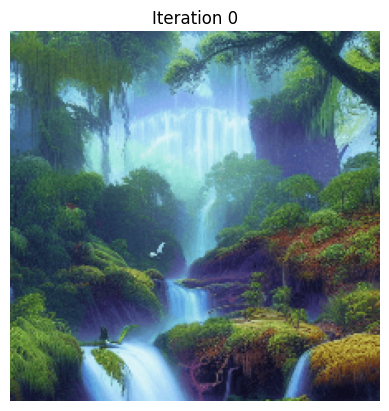

Iteration 300: Loss: 2.156320619281232e+24


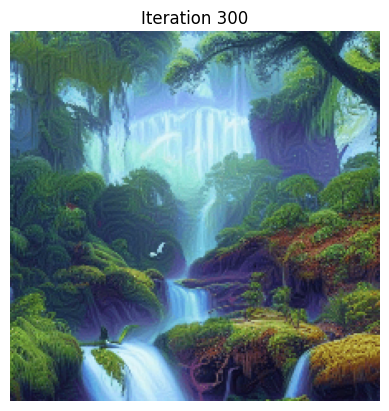

Iteration 600: Loss: 2.0053103841470748e+24


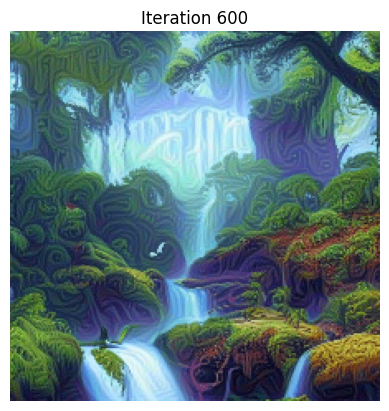

Iteration 900: Loss: 1.8362053342284894e+24


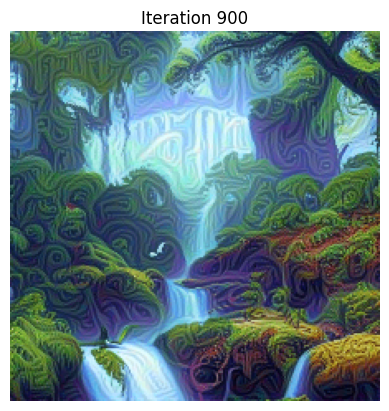

Iteration 1200: Loss: 1.6662763777796743e+24


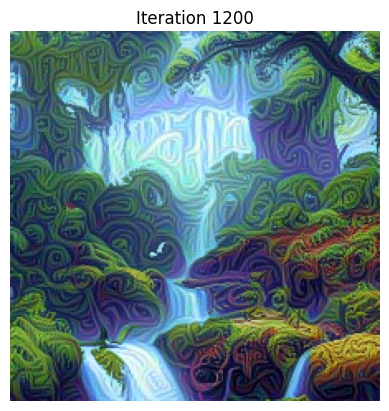

In [229]:
# Generated image initialized as the content image
generated_image = tf.Variable(content_image, dtype=tf.float32)

optimizer = tf.optimizers.Adam(learning_rate=0.01)
num_iterations = 1500
content_weight = 1
style_weight = 1e6
style_weights = {'block1_conv1': 0.5, 'block2_conv1': 0.375, 'block3_conv1': 0.1, 'block4_conv1': 0.1, 'block5_conv1': 0.4}

for i in range(num_iterations):

    with tf.GradientTape() as tape:
        # Compute total loss
        loss = compute_total_loss(generated_image, content_features, style_features, content_weight, style_weight, style_weights)

    # Backprop
    grads = tape.gradient(loss, generated_image)

    # Apply gradients to stylize the generated image
    optimizer.apply_gradients([(grads, generated_image)])

    # Print loss every 100 iterations
    if i % 300 == 0:
        print(f"Iteration {i}: Loss: {loss.numpy()}")
        # Display the current generated image
        plt.imshow(deprocess_image(generated_image.numpy()[0]))
        plt.title(f"Iteration {i}")
        plt.axis('off')
        plt.show()


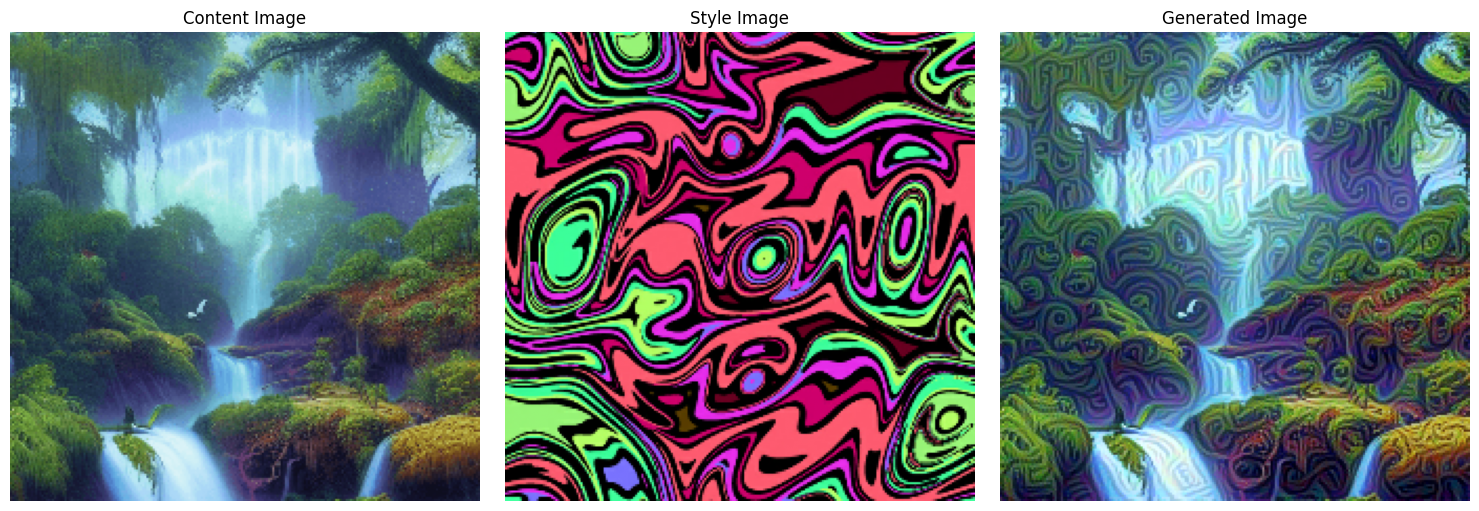

In [230]:
def display_images(content_image, style_image, generated_image):
    # Deprocess images for display
    content_display = deprocess_image(content_image.numpy()[0])
    style_display = deprocess_image(style_image.numpy()[0])
    generated_display = deprocess_image(generated_image.numpy()[0])
    
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Content Image
    ax1.imshow(content_display)
    ax1.set_title("Content Image")
    ax1.axis('off')
    
    # Style Image
    ax2.imshow(style_display)
    ax2.set_title("Style Image")
    ax2.axis('off')
    
    # Generated Image
    ax3.imshow(generated_display)
    ax3.set_title("Generated Image")
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
display_images(content_image, style_image, generated_image)

In [232]:
from PIL import Image

def save_image(tensor, filename):
    # Deprocess the image
    image = deprocess_image(tensor.numpy()[0])
    
    # Convert to values between 0 and 255
    image = (image * 255).astype(np.uint8)
    
    # Convert to PIL Image and save
    Image.fromarray(image).save(filename)

# Save the generated image
# save_image(generated_image, "generated_image_nature_swiggle.jpg")